# Analysis of Acoustic Data

In [1]:
import glob
import visionpy.io.load_kwave as lk
import matplotlib.pyplot as plt
import numpy as np
from visionpy.recon.backproject import circle_backproject
from visionpy.recon.utils import FieldOfView2D, interpolate_line
from pymcx import load_mcx_settings
import os
import pandas as pd
import matplotlib

from spectra import blood_mu_a, melanosome_mu_a, water_mu_a

matplotlib.rcParams['figure.figsize'] = (5,4)
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 18})

In [2]:
parameters = pd.read_csv("../Exp1/params.csv", index_col=0)
parameters.loc[:, parameters.nunique()>1]

# View the phantom
settings = os.path.join("../Exp1", parameters["SettingsFile"].iloc[0])
volfile = os.path.join("../Exp1", parameters["VolumeFile"].iloc[0])

# Load the phantom settings.
mcx_settings = load_mcx_settings(settings)
dimension = tuple(mcx_settings["Domain"]["Dim"])
volume = np.fromfile(volfile, dtype="uint8").reshape(dimension + (-1,), order="F")
vessel_roi = volume[:, 100, :, 0]==4

In [3]:
ms_results = []
# Define in the independent variable which is varied in the experiment.
variable = "Melanin"
labels = parameters[variable].unique()
Nx = 200
Ny = 200
for dep_variable in labels:
    print(dep_variable)
    selection = parameters[parameters[variable] == dep_variable]
    test = np.zeros((Nx, Ny, 21), order="F")
    for i, result_file in enumerate(selection["OutputFile"]):
        root, __ = os.path.splitext(result_file)
        file = root + ".mat"
        fov = FieldOfView2D(-0.006, 0.006, -0.006,0.006, Nx, Ny)
        pa = lk.load_kwave(file)
        test[:, :, i] = circle_backproject(pa, 1500, fov,as_single=False).T/1e16
    ms_results.append(test)

0.0001
0.01
0.03
0.1
0.2
0.4


In [4]:
#### Load the basis spectra
wavelengths = parameters["Wavelength"].unique()
hb = blood_mu_a(wavelengths, 0, water = False)
hbo2 = blood_mu_a(wavelengths, 1, water = False)
water = water_mu_a(wavelengths)
melanin = melanosome_mu_a(wavelengths)
test = np.ones_like(wavelengths)

# Calculate the forward and (pseudo)-inverse matrices
#spectra_matrix = np.array([hb, hbo2, water, melanin]).T
spectra_matrix = np.array([hb, hbo2, water, melanin]).T
inv_matrix = np.linalg.pinv(spectra_matrix)

# Apply the unmixing matrix
unmixed = [np.dot(result, inv_matrix.T) for result in ms_results]
so2 = [M[:, :, 1]/(M[:, :, 1] + M[:, :, 0]) for M in unmixed]
THb = [M[:, :, 1]+M[:, :, 0] for M in unmixed]

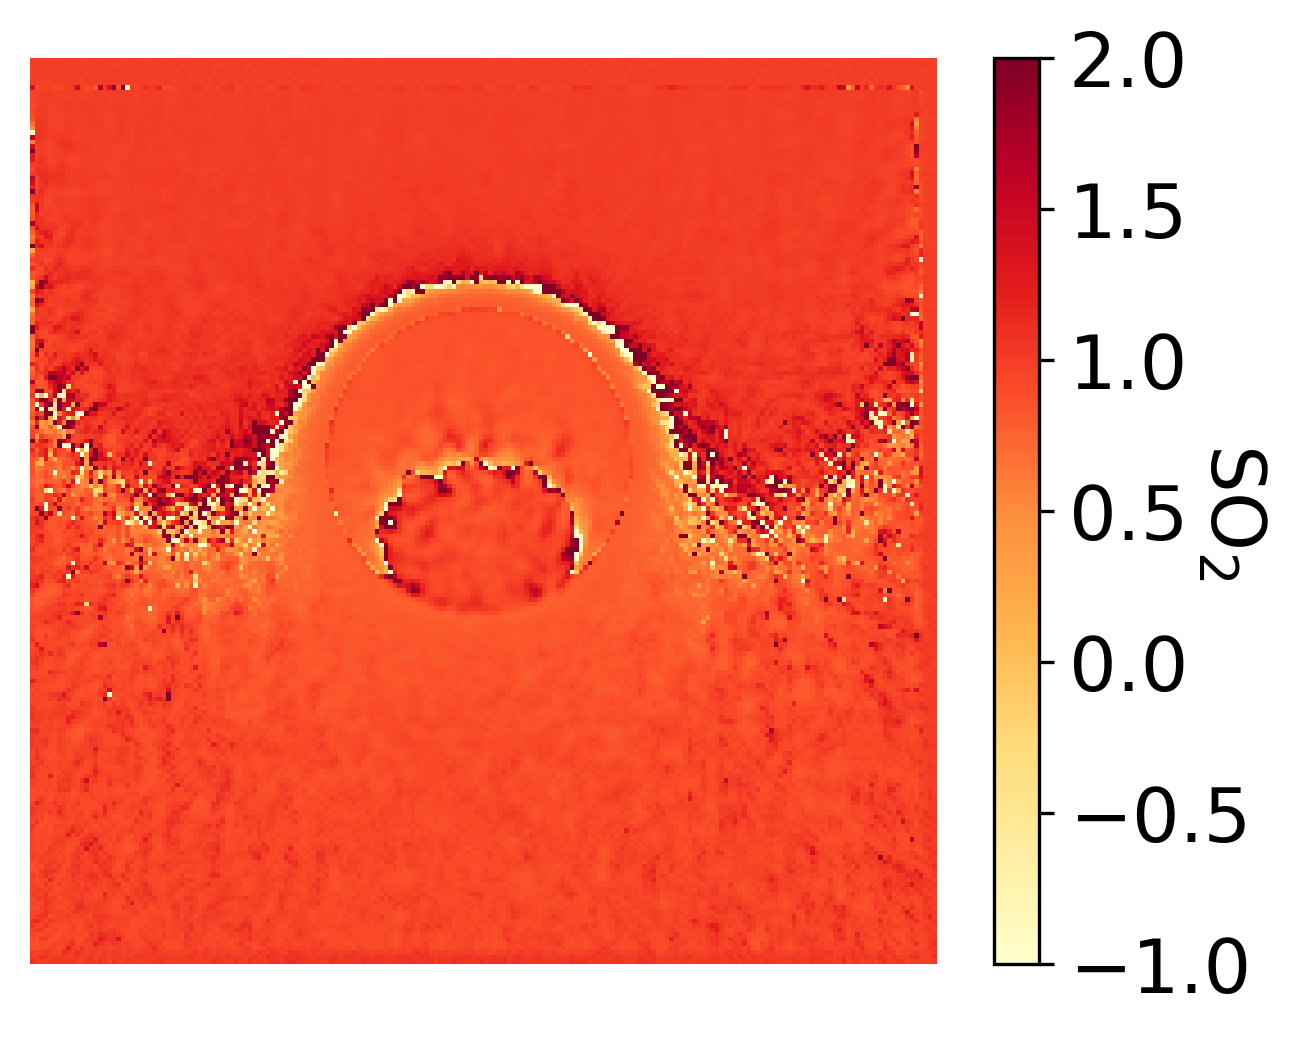

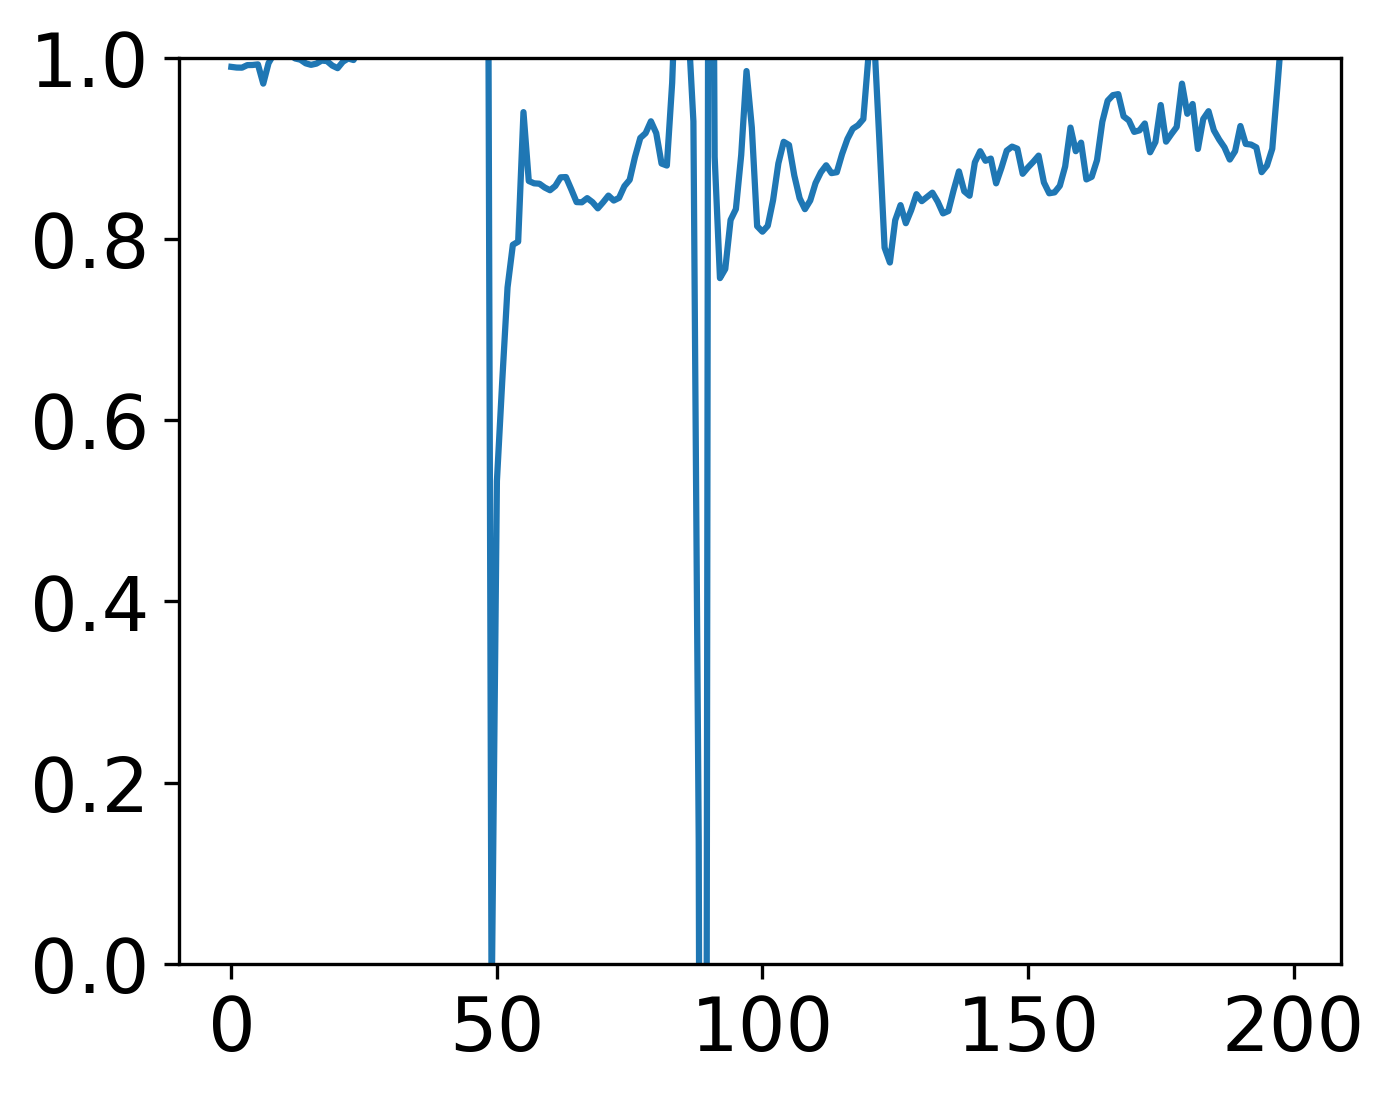

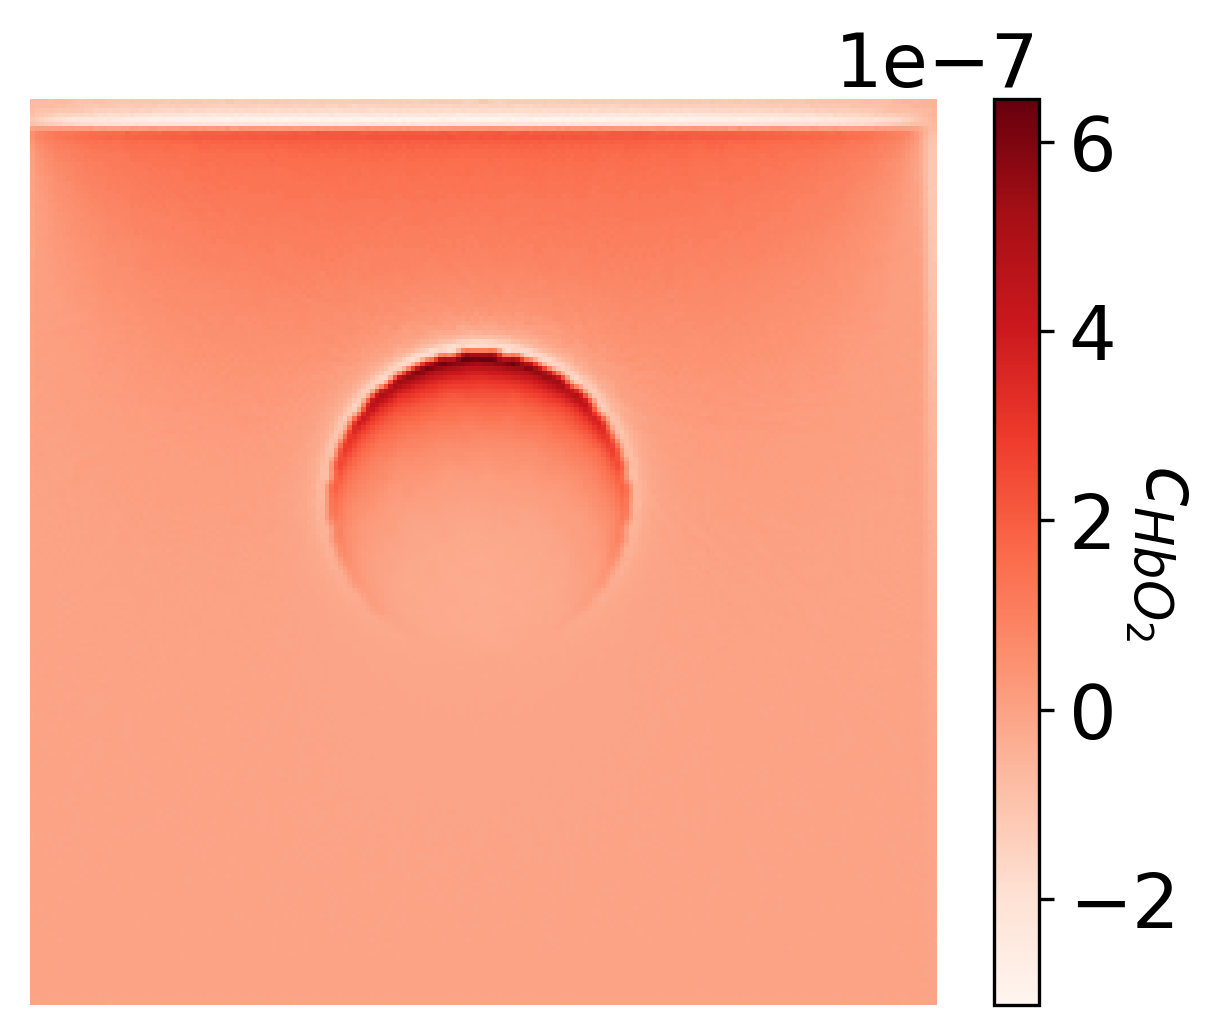

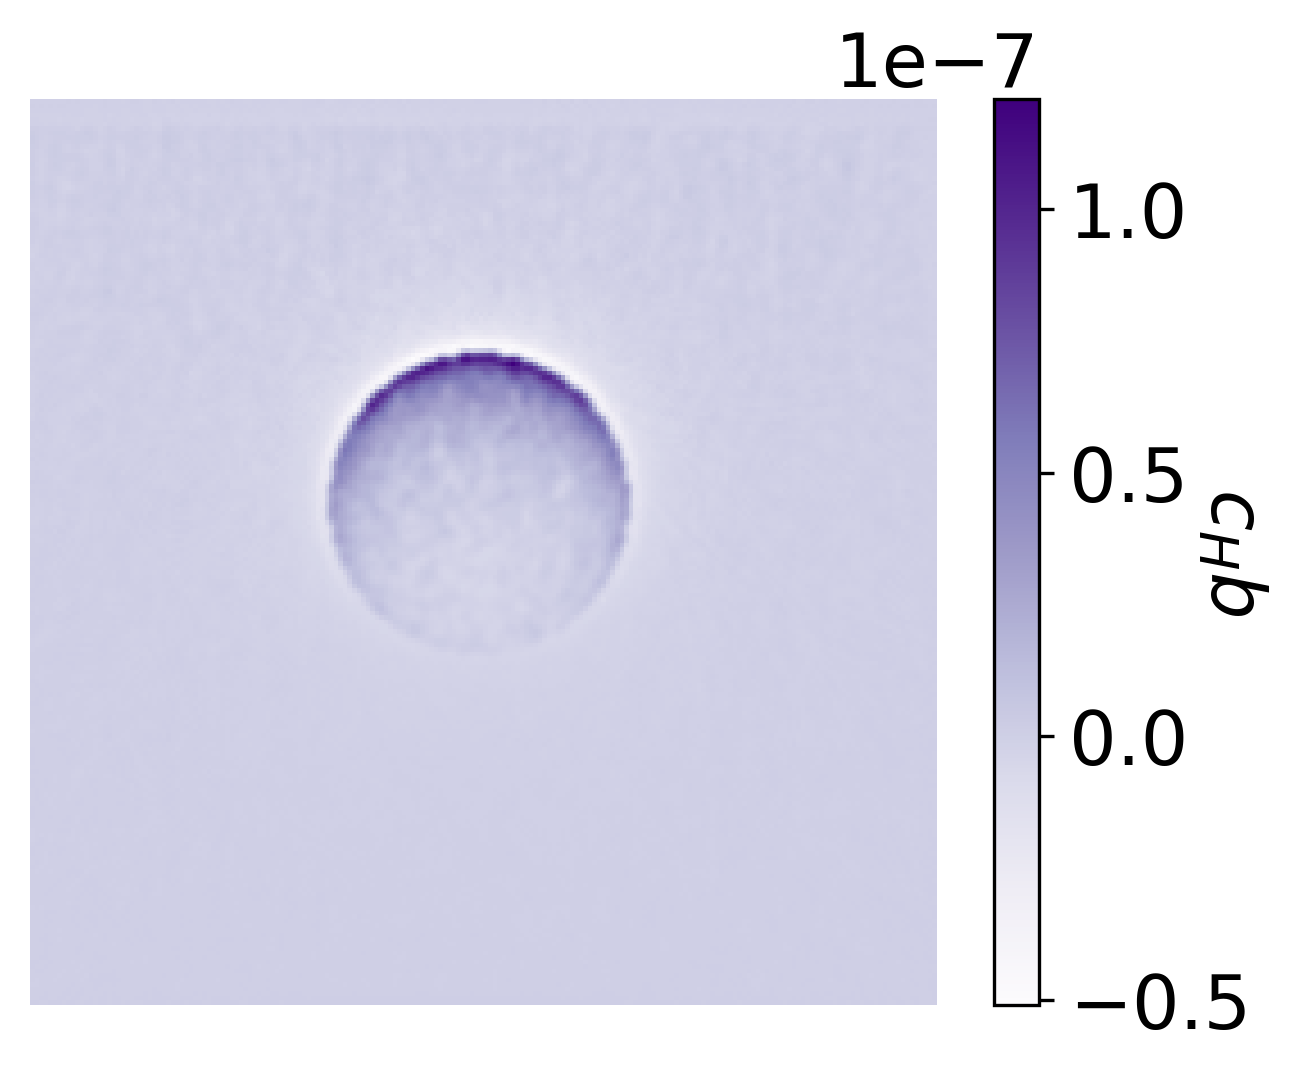

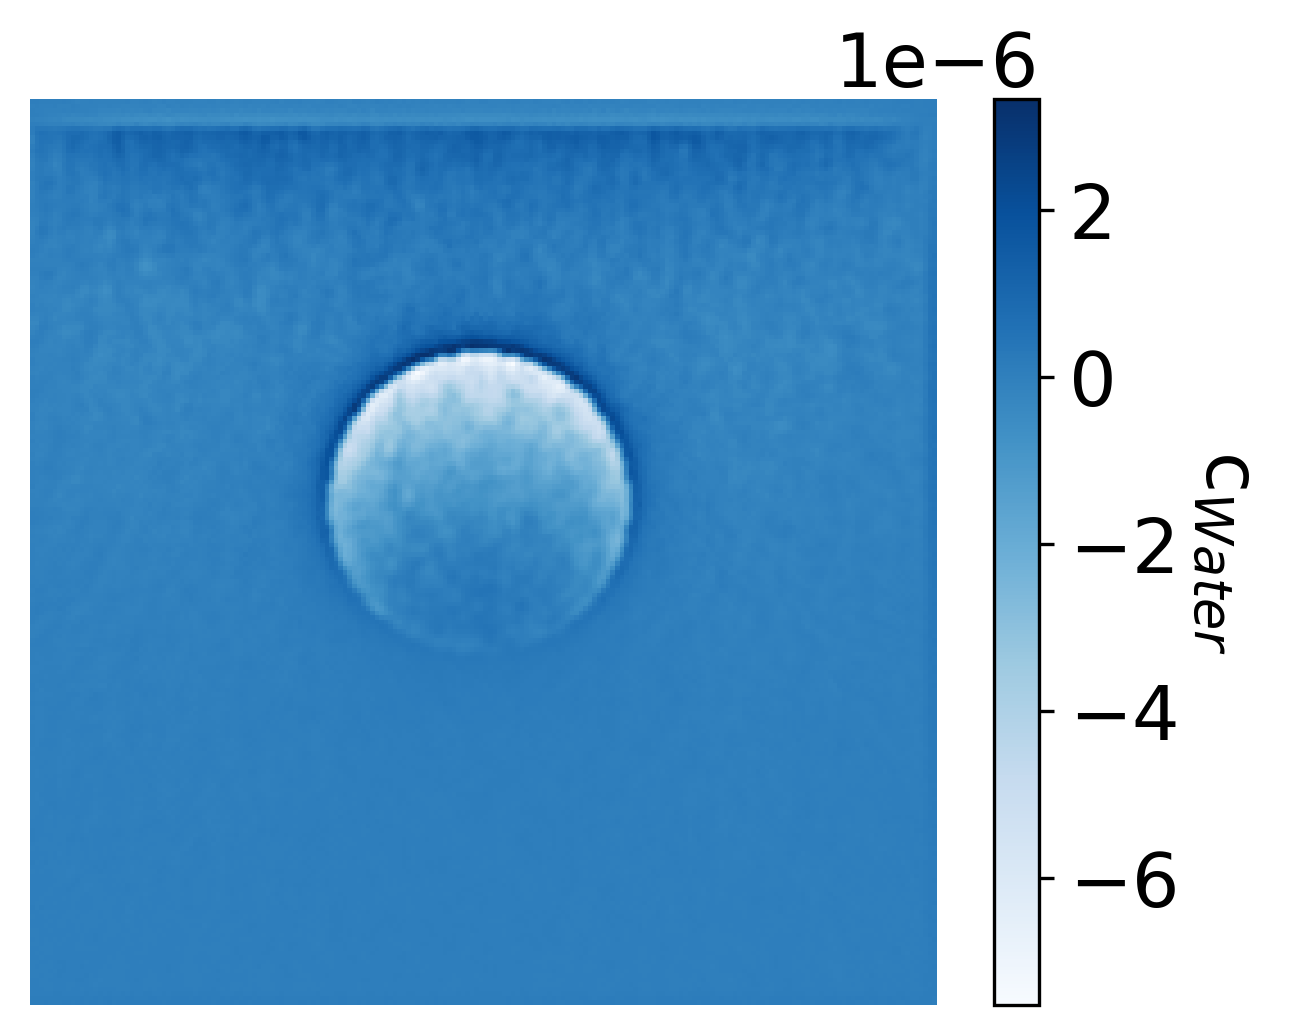

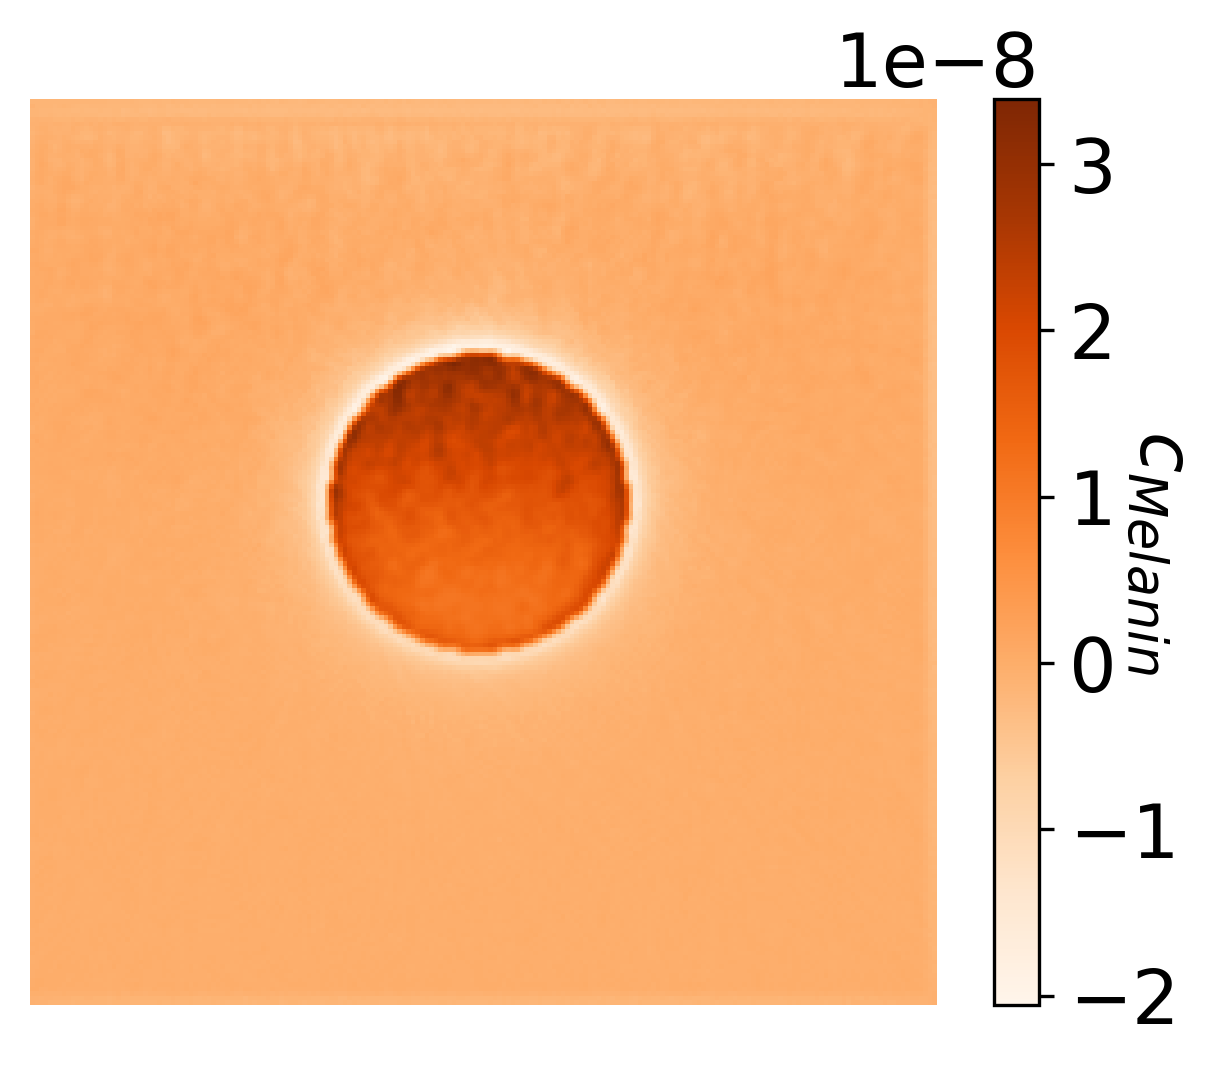

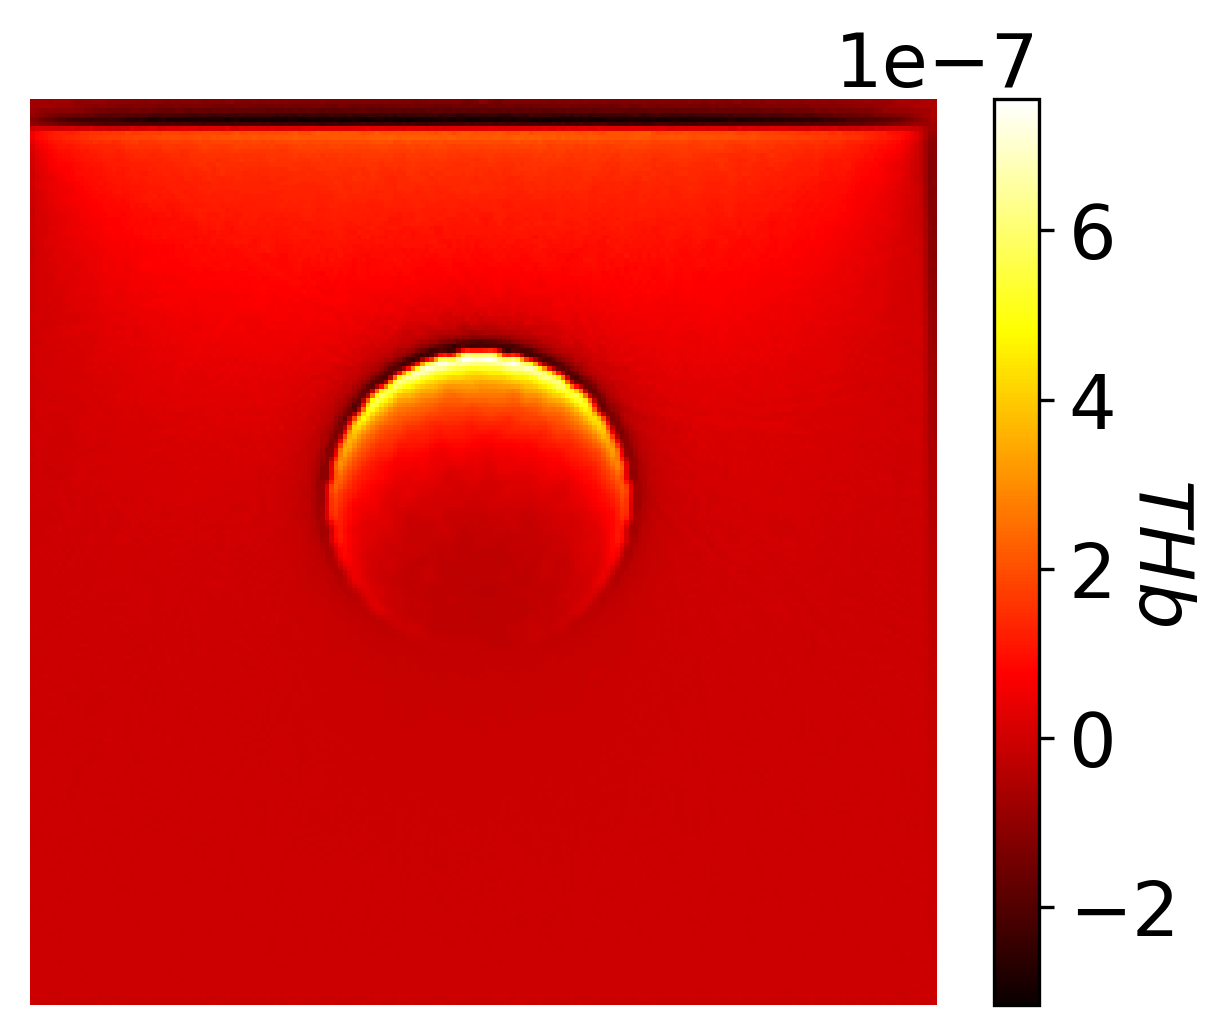

In [5]:
n=0
# SO2
plt.imshow(so2[n].T, cmap="YlOrRd", clim=(-1,2))
cb = plt.colorbar()
#cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('SO$_2$', rotation=270)
plt.axis("off")
plt.savefig("../FiguresOutput/acoustic_so2.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
plt.plot(so2[n][100,:])
plt.ylim([0,1])
plt.show()
# HbO2
plt.imshow(unmixed[n][:, :, 1].T, cmap="Reds")
cb = plt.colorbar()
#cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$c_{HbO_2}$', rotation=270)
plt.axis("off")
plt.savefig("../FiguresOutput/acoustic_hb02.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# Hb
plt.imshow(unmixed[n][:, :, 0].T, cmap="Purples")
cb = plt.colorbar()
#cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$c_Hb$', rotation=270)
plt.axis("off")
plt.savefig("../FiguresOutput/acoustic_hb.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# Water
plt.imshow(unmixed[n][:, :, 2].T, cmap="Blues")
cb = plt.colorbar()
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('c$_{Water}$', rotation=270)
plt.axis("off")
plt.savefig("../FiguresOutput/acoustic_water.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# Melanin
plt.imshow(unmixed[n][:, :, 3].T, cmap="Oranges")
cb = plt.colorbar()
#cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$c_{Melanin}$', rotation=270)
plt.axis("off")
plt.savefig("../FiguresOutput/acoustic_melanin.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()
# THb
plt.imshow(THb[n].T, cmap="hot")
cb = plt.colorbar()
#cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$THb$', rotation=270)
plt.axis("off")
plt.savefig("../FiguresOutput/acoustic_thb.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

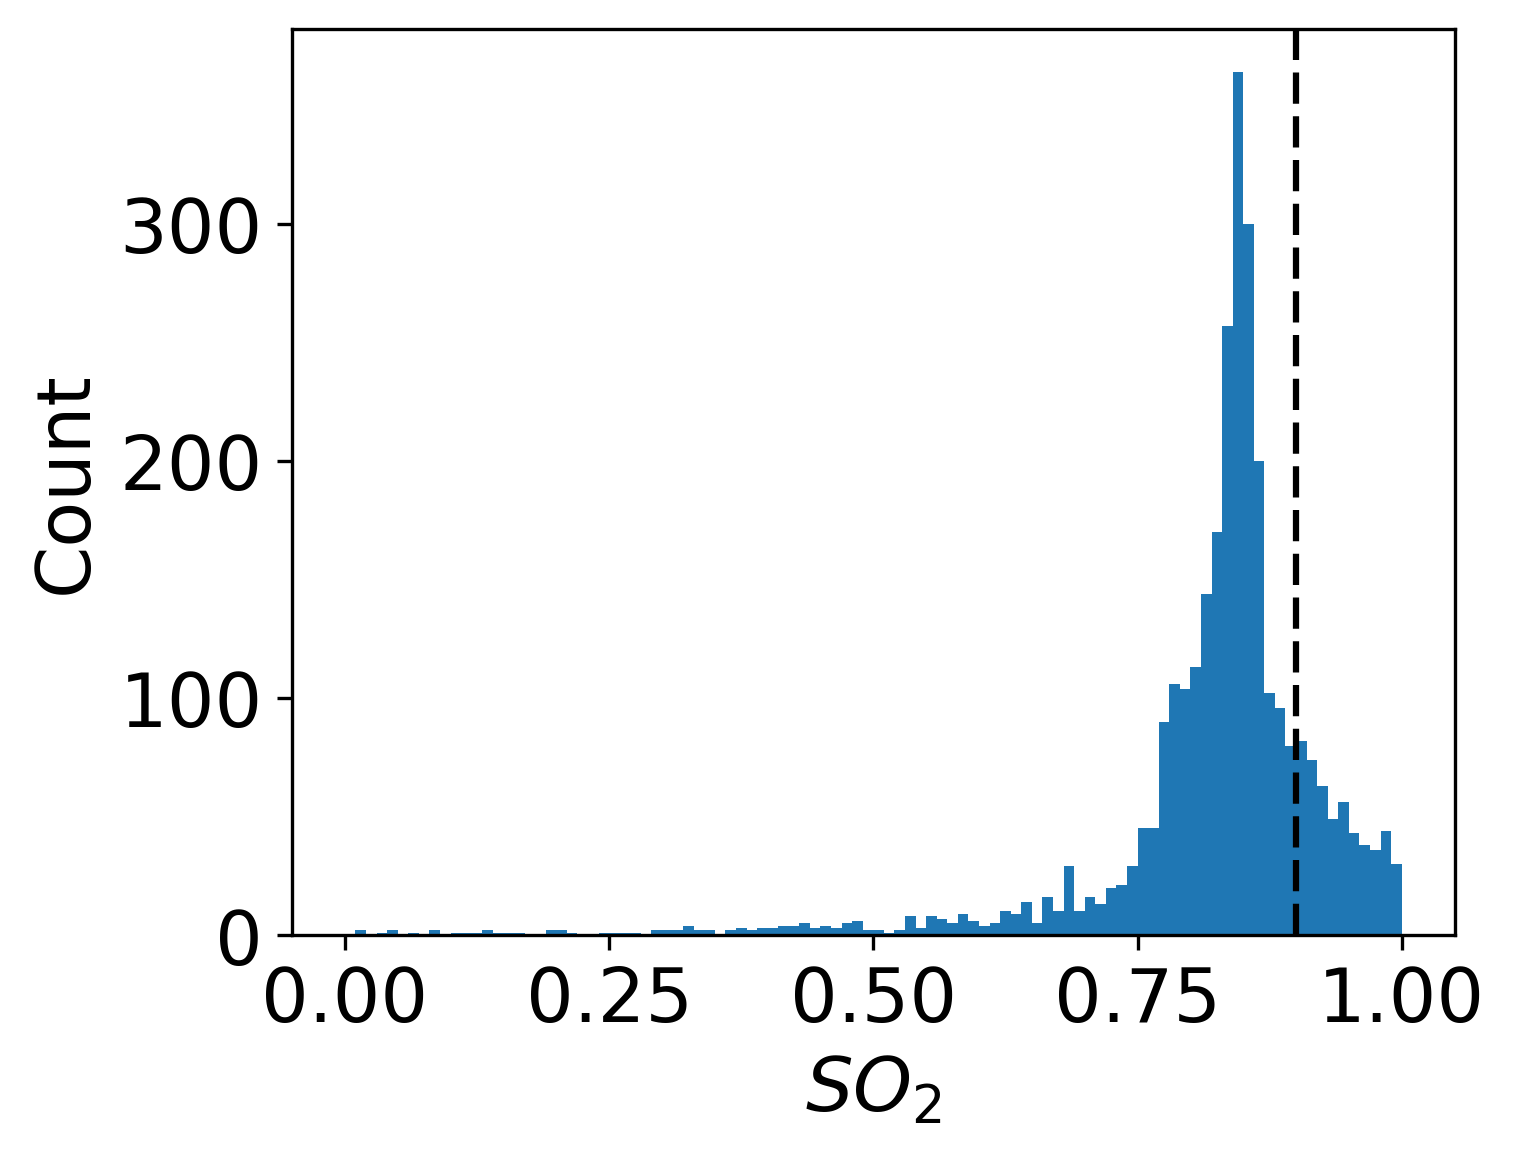

In [6]:
plt.hist(so2[n][vessel_roi], range = (0,1), bins=100)
plt.xlabel("$SO_2$")
plt.ylabel("Count")
plt.axvline(0.9, c="k", dashes=(5,2))
plt.savefig("../FiguresOutput/acoustic_so02_hist.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()